In [41]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import re
import numpy as np
# import spacy
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy



# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

SyntaxError: invalid syntax (<ipython-input-41-108236f85d2f>, line 26)

In [5]:
from time import time
print("Loading dataset...")
t0 = time()

a=0 
b=0
c=0
data=[]
date_year=[]
data_ab=[]
f=open("savedrecs.txt","r",encoding='utf-8')
f.readline()
for line in f:
    #print (line.startswith('AB'))K1TI
    if line.startswith('TI') == True :
        if len(line.lstrip('TI').strip())>0:
            A=line.lstrip('TI').strip()
            a=1
            
    if line.startswith('PY') == True :
        if len(line.lstrip('PY').strip())>0:
            B=line.lstrip('PY').strip()
            b=2
            
    if line.startswith('AB') == True :
        if len(line.lstrip('AB').strip())>0:
            C=line.lstrip('AB').strip() 
            c=3

    if a==1 and b==2 and c==3:
        data.append(A) 
        date_year.append(B) 
        data_ab.append(C)     
        a=0
        b=0
        c=0
        
print("done in %0.3fs." % (time() - t0))


Loading dataset...
done in 0.106s.


In [6]:
print(len(data_ab))

993


In [7]:
print(len( date_year))

993


In [9]:
print(len(data))

993


In [10]:
from pandas.core.frame import DataFrame
#列表b
c={"title" : data,
   "year" : date_year,
  "abstract" : data_ab}#将列表a，b转换成字典
DATA=DataFrame(c)#将字典转换成为数据框
print(DATA)


                                                 title  year  \
0    A survey of machine learning for big data proc...  2016   
1    Deep Learning for Intelligent Wireless Network...  2018   
2    Learning Hierarchical Features for Scene Labeling  2013   
3    Autonomous Structural Visual Inspection Using ...  2018   
4    Remote Sensing Image Fusion With Deep Convolut...  2018   
..                                                 ...   ...   
988  Deep learning model for real-time image compre...  2017   
989  Towards automatic pulmonary nodule management ...  2020   
990  Deep-learning-assisted diagnosis for knee magn...  2017   
991  A Second-Order Multi-Agent Network for Bound-C...  2018   
992  NetSurfP-2.0: Improved prediction of protein s...  2015   

                                              abstract  
0    There is no doubt that big data are now rapidl...  
1    As a promising machine learning tool to handle...  
2    Scene labeling consists of labeling each pixel...  
3  

In [188]:
documents=list(DATA['title'])

In [189]:
# documents

In [190]:
time=DATA['year']
DATA['year']=time.str.slice(0,4) 

In [191]:
print(DATA['year'])

0      2016
1      2018
2      2013
3      2018
4      2018
       ... 
988    2017
989    2020
990    2017
991    2018
992    2015
Name: year, Length: 993, dtype: object


In [192]:
time_stamps=np.arange(int(DATA.year.min(axis=0)),int(DATA.year.max(axis=0))+1,1)
time_stamps=list(time_stamps)


# find out the time slice
gp=DATA.groupby(by=['year'])
total_yearly_list=list(gp.size())

In [193]:
print(time_stamps)
print(total_yearly_list)

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
[15, 13, 29, 30, 45, 54, 104, 203, 201, 207, 92]


In [194]:
stoplist=stopwords
#nlp = spacy.load('en')

nlp = spacy.load('en_core_web_sm')

# doc = nlp("Wall Street Journal just published an interesting piece on crypto currencies")
# for chunk in doc.noun_chunks:
#     print(chunk.text, chunk.label_, chunk.root.text)

stoplist = set('for a an of the with on and to in at from as by about is was where that = or were this their are we be through - re its it'.split())

texts = []
for document in documents:
    text = [word.text for word in nlp(document.lower()).noun_chunks if word not in stoplist]
    texts.append(text)

In [196]:
import os
from collections import  defaultdict
# drop the words only appers once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

dictionary = corpora.Dictionary(texts)   # generate the dictionary
dictionary.compactify() #

dictionary.save(os.path.join('dictionary.dict')) # store the dictionary, for future reference
print(dictionary)


Dictionary(188 unique tokens: ['a survey', 'a comprehensive survey', 'deep learning', 'deep convolutional neural network', 'face recognition']...)


In [197]:
import os
#Save vocabulary
vocFile = open(os.path.join( 'vocabulary.dat'),'w',encoding='utf-8')
for word in dictionary.values():
    print(word)
    vocFile.write(word+'\n')
vocFile.close()
print(vocFile)


a survey
a comprehensive survey
deep learning
deep convolutional neural network
face recognition
genomics
applications
artificial intelligence
covid-19
-
identification
re
its
machine learning
approaches
trends
deep convolutional neural networks
the use
deep learning approaches
extreme learning machine
machine
a review
big data
healthcare
medicine
opportunities
neural networks
the future
land
urban land use
attention
computer vision
convolutional neural
an overview
hyperspectral image classification
immersive virtual reality
survey
use
communications
detection
development
validation
research
ucsf chimerax
a deep learning approach
evaluation
the prediction
convolutional neural networks
online reviews
classification
fault diagnosis
transfer
prediction
deep convolutional networks
it
models
application
wireless networks
uav
assessment
the-art
the accuracy
presence
virtual reality
face
artificial intelligence and machine learning
radiology
algorithms
reinforcement learning
a single image
re

In [198]:
#Prevent storing the words of each document in the RAM
class MyCorpus(object):
     def __iter__(self):
         
         for text in texts:

            yield dictionary.doc2bow(text)
            

corpus_memory_friendly = MyCorpus()

multFile = open(os.path.join( 'foo-mult.dat'),'w')

for vector in corpus_memory_friendly: # load one vector into memory at a time
    multFile.write(str(len(vector)) + ' ')
    for (wordID, weigth) in vector:
        multFile.write(str(wordID) + ':' + str(weigth) + ' ')

    multFile.write('\n')
    
multFile.close()

print(multFile)



<_io.TextIOWrapper name='foo-mult.dat' mode='w' encoding='cp936'>


In [199]:
print(type(vocFile))

<class '_io.TextIOWrapper'>


In [200]:
time_slice=total_yearly_list
print(time_slice)

[15, 13, 29, 30, 45, 54, 104, 203, 201, 207, 92]


In [201]:
print(type(corpus_memory_friendly))

<class '__main__.MyCorpus'>


In [202]:
print(dictionary)

Dictionary(188 unique tokens: ['a survey', 'a comprehensive survey', 'deep learning', 'deep convolutional neural network', 'face recognition']...)


In [203]:
from gensim.models import LdaSeqModel
#use LdaSeqModel to generate DTM results
#ldaseq = LdaSeqModel(corpus=corpus_memory_friendly, id2word=dictionary, time_slice=time_slice, num_topics=5)
ldaseq = LdaSeqModel(corpus=corpus_memory_friendly, id2word=dictionary, time_slice=time_slice, num_topics=12)
# for given time, the distriibution of each topic 
ldaseq.print_topics(time=1)
# for given topic the word distribution over time


D:\software\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
D:\software\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
D:\software\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
D:\software\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
D:\software\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
D:\softw

[[('deep neural networks', 0.18210788861049795),
  ('uav', 0.10852909904321323),
  ('computer vision', 0.10756360056314117),
  ('what', 0.06913248305237393),
  ('spectral-spatial classification', 0.06829277907200741),
  ('edge', 0.04983786604097399),
  ('ship detection', 0.04965154174522185),
  ('multimodal', 0.015171445499828608),
  ('a survey', 0.014253040154247259),
  ('virtual reality', 0.010583834413099425),
  ('face recognition', 0.010583834413099416),
  ('the effects', 0.010583834413099416),
  ('flash flood', 0.010543144032017424),
  ('a comparative assessment', 0.010543144032017424),
  ('-demand', 0.009811352046587807),
  ('presence', 0.005973249742079169),
  ('algorithms', 0.005973249742079169),
  ('hyperspectral image', 0.005973249742079169),
  ('optimization', 0.005973249742079169),
  ('it', 0.005973249742079169)],
 [('artificial intelligence', 0.3105176426691252),
  ('fault diagnosis', 0.05363983668825081),
  ('deep learning approaches', 0.021508988815347296),
  ('ground', 

In [185]:
DTM_topic_0=ldaseq.print_topic_times(topic=0, top_terms=10)
DTM_topic_1=ldaseq.print_topic_times(topic=1, top_terms=10)
DTM_topic_2=ldaseq.print_topic_times(topic=2, top_terms=10)
DTM_topic_3=ldaseq.print_topic_times(topic=3, top_terms=10)
DTM_topic_4=ldaseq.print_topic_times(topic=4, top_terms=10)
DTM_topic_5=ldaseq.print_topic_times(topic=5, top_terms=10)
DTM_topic_6=ldaseq.print_topic_times(topic=6, top_terms=10)
DTM_topic_7=ldaseq.print_topic_times(topic=7, top_terms=10)
DTM_topic_8=ldaseq.print_topic_times(topic=8, top_terms=10)
DTM_topic_9=ldaseq.print_topic_times(topic=9, top_terms=10)
DTM_topic_10=ldaseq.print_topic_times(topic=10, top_terms=10)


In [186]:
def topic_time(DTM_topic,time_stamps):  
    for i in range(len(time_slice)-1):
        if i==0:
            temp_a1=pd.DataFrame(DTM_topic[i])
            temp_a2=pd.DataFrame(DTM_topic[i+1])
            temp_a1.columns = ['words', time_stamps[i]]
            temp_a2.columns = ['words', time_stamps[i+1]]
            temp_a1=pd.merge(temp_a1,temp_a2)
        else:
            temp_a2=pd.DataFrame(DTM_topic[i+1])
            temp_a2.columns = ['words', time_stamps[i+1]]
            temp_a1=pd.merge(temp_a1,temp_a2)
    topic_words_time=temp_a1
    return topic_words_time
   
topic1_words_time=topic_time(DTM_topic_0,time_stamps)
topic2_words_time=topic_time(DTM_topic_1,time_stamps)
topic3_words_time=topic_time(DTM_topic_2,time_stamps)
topic4_words_time=topic_time(DTM_topic_3,time_stamps)
topic5_words_time=topic_time(DTM_topic_4,time_stamps)
topic6_words_time=topic_time(DTM_topic_5,time_stamps)
topic7_words_time=topic_time(DTM_topic_6,time_stamps)
topic8_words_time=topic_time(DTM_topic_7,time_stamps)
topic9_words_time=topic_time(DTM_topic_8,time_stamps)
topic10_words_time=topic_time(DTM_topic_9,time_stamps)
topic11_words_time=topic_time(DTM_topic_10,time_stamps)
topic12_words_time=topic_time(DTM_topic_11,time_stamps)

In [187]:
print(topic1_words_time)

                     words      2011      2012      2013      2014      2015  \
0              the authors  0.014815  0.014903  0.014989  0.015047  0.015104   
1               this paper  0.014749  0.014828  0.014894  0.014917  0.014933   
2               this study  0.012600  0.012542  0.012478  0.012447  0.012414   
3                  the use  0.012428  0.012492  0.012552  0.012646  0.012738   
4  artificial intelligence  0.012125  0.012170  0.012205  0.012207  0.012206   
5                 students  0.011757  0.011816  0.011870  0.011955  0.012035   
6            the potential  0.011214  0.011267  0.011317  0.011393  0.011467   
7               technology  0.010573  0.010621  0.010666  0.010734  0.010800   
8               algorithms  0.009982  0.010025  0.010065  0.010124  0.010183   
9                     they  0.009359  0.009397  0.009431  0.009483  0.009534   

       2016      2017      2018      2019      2020      2021  
0  0.015173  0.015301  0.015578  0.015557  0.015676  0.

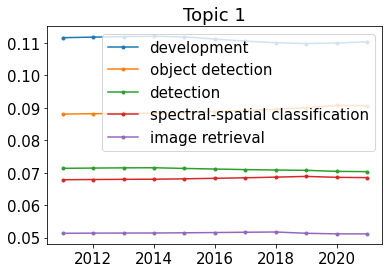

In [161]:
#plot the dynamic movement of topic 1
topic1_words=list(topic1_words_time['words'])
plt.figure()
for i in range(0,5):
    plt.plot(time_stamps, topic1_words_time.iloc[i,1:],marker=".",label=topic1_words[i])
#plt.xlim((-1, 2))
#plt.ylim((0, 0.02))
plt.legend(loc='best')
plt.title('Topic 1')
plt.savefig('Topic4-1.png',transparent=True)
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.show()

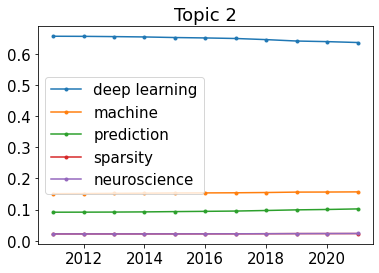

In [162]:
#plot the dynamic movement of topic2
topic=topic2_words_time
topic_words=list(topic['words'])
plt.figure()
for i in range(0,5):
    plt.plot(time_stamps, topic.iloc[i,1:],marker=".",label=topic_words[i])
#plt.xlim((-1, 2))
#plt.ylim((0, 0.02))
plt.legend(loc='best')
plt.title('Topic 2')
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.savefig('Topic4-2.png',transparent=True)
plt.show()

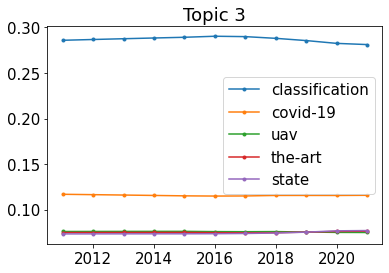

In [163]:

#plot the dynamic movement of topic3
topic=topic3_words_time
topic_words=list(topic['words'])
plt.figure()
for i in range(0,5):
    plt.plot(time_stamps, topic.iloc[i,1:],marker=".",label=topic_words[i])
#plt.xlim((-1, 2))
#plt.ylim((0, 0.02))
plt.legend(loc='best')
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.title('Topic 3')
plt.savefig('Topic4-3.png',transparent=True)
plt.show()

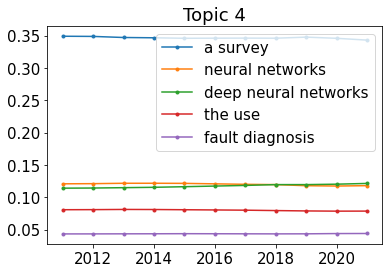

In [164]:
#plot the dynamic movement of topic4
topic=topic4_words_time
topic_words=list(topic['words'])
plt.figure()
for i in range(0,5):
    plt.plot(time_stamps, topic.iloc[i,1:],marker=".",label=topic_words[i])
#plt.xlim((-1, 2))
#plt.ylim((0, 0.02))
plt.legend(loc='best')
plt.title('Topic 4')
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.savefig('Topic4-4.png',transparent=True)
plt.show()

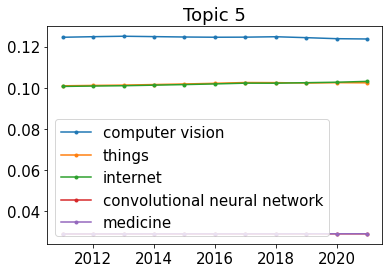

In [165]:
#plot the dynamic movement of topic4
topic=topic5_words_time
topic_words=list(topic['words'])
plt.figure()
for i in range(0,5):
    plt.plot(time_stamps, topic.iloc[i,1:],marker=".",label=topic_words[i])
#plt.xlim((-1, 2))
#plt.ylim((0, 0.02))
plt.legend(loc='best')
plt.title('Topic 5')
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.savefig('Topic4-5.png',transparent=True)
plt.show()

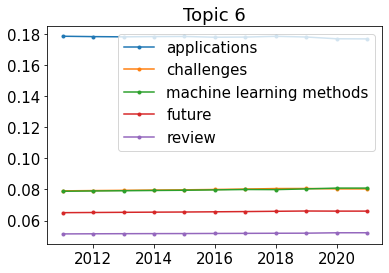

In [166]:
#plot the dynamic movement of topic4
topic=topic6_words_time
topic_words=list(topic['words'])
plt.figure()
for i in range(0,5):
    plt.plot(time_stamps, topic.iloc[i,1:],marker=".",label=topic_words[i])
#plt.xlim((-1, 2))
#plt.ylim((0, 0.02))
plt.legend(loc='best')
plt.title('Topic 6')
plt.rcParams.update({'font.size': 15})     #设置图例字体大小
plt.savefig('Topic4-6.png',transparent=True)
plt.show()